# Models

Firstly, we need to import the libraries we will use.

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

Secondly, we need to load the data.

In [205]:
train = pd.read_csv('data/train_engineeredV3.csv')
test = pd.read_csv('data/test_engineeredV3.csv')

In the following models, we will predict the log revenue and then convert to the revenue.
Because based on the previous trials, these method will have better score than dirctly predict revenue.

In [206]:
# create log features and log revenue as target
train['log_budget']=np.log1p(train['original_budget'])
test['log_budget']=np.log1p(test['original_budget'])
train['log_budget_p'] = np.log1p(train['budget_processed'])
test['log_budget_p'] = np.log1p(test['budget_processed'])

These are the features we engineered and will used in the following models

In [207]:
# print the title of each column of the train dataset
print(train.columns.values)

['id' 'belongs_to_collection' 'original_budget' 'budget_processed'
 'genre_rank' 'num_genres' 'has_homepage' 'originally_english' 'topStudio'
 'numTopStudios' 'num_studios' 'studioRank' 'num_production_countries'
 'topCountry' 'countryRank' 'usa_produced' 'release_date' '1960s' '1970s'
 '1980s' '1990s' '2000s' '2010s' 'mondayRelease' 'tuesdayRelease'
 'wednesdayRelease' 'thursdayRelease' 'fridayRelease' 'saturdayRelease'
 'sundayRelease' 'Winter' 'Fall' 'Spring' 'Summer' 'runtime_processed'
 'spoken_english' 'num_languages' 'has_tagline' 'num_keywords'
 'numTopKeywords' 'keywordRank' 'cast_num' 'topLeadActor' 'numTopActors'
 'actorRanks' 'topActorRank' 'crew_num' 'topLeadDirector'
 'numTopDirectors' 'directorsRank' 'topLeadExecProd' 'numTopExecProd'
 'execProdRank' 'topLeadProducer' 'numTopProducers' 'producersRank'
 'topLeadComposer' 'numTopComposers' 'composersRank'
 'topLeadDirectorPhoto' 'numTopDirectorsPhoto' 'directorsPhotoRank'
 'topLeadEditor' 'numTopEditors' 'editorsRank' 'bud

In [208]:
# print the title of each column of the test dataset
print(test.columns.values)

['Unnamed: 0' 'imdb_id' 'id' 'belongs_to_collection' 'original_budget'
 'budget_processed' 'genre_rank' 'num_genres' 'has_homepage'
 'originally_english' 'topStudio' 'numTopStudios' 'num_studios'
 'studioRank' 'num_production_countries' 'topCountry' 'countryRank'
 'usa_produced' 'release_date' '1960s' '1970s' '1980s' '1990s' '2000s'
 '2010s' 'mondayRelease' 'tuesdayRelease' 'wednesdayRelease'
 'thursdayRelease' 'fridayRelease' 'saturdayRelease' 'sundayRelease'
 'Winter' 'Fall' 'Spring' 'Summer' 'runtime_processed' 'spoken_english'
 'num_languages' 'has_tagline' 'num_keywords' 'numTopKeywords'
 'keywordRank' 'cast_num' 'topLeadActor' 'numTopActors' 'actorRanks'
 'topActorRank' 'crew_num' 'topLeadDirector' 'numTopDirectors'
 'directorsRank' 'topLeadExecProd' 'numTopExecProd' 'execProdRank'
 'topLeadProducer' 'numTopProducers' 'producersRank' 'topLeadComposer'
 'numTopComposers' 'composersRank' 'topLeadDirectorPhoto'
 'numTopDirectorsPhoto' 'directorsPhotoRank' 'topLeadEditor'
 'numTopEdi

These is features we selected to use.

In [209]:
#Model training, based on correlations extracted at DataAnalysis part
feature_regression = ['belongs_to_collection', 'original_budget', 'budget_processed',
                      'genre_rank', 'num_genres', 'has_homepage', 'originally_english', 'topStudio',
                            'numTopStudios', 'num_studios', 'studioRank', 'num_production_countries',
                                'topCountry', 'countryRank', 'usa_produced', '1960s', '1970s',
                                        '1980s', '1990s', '2000s', '2010s', 'mondayRelease', 'tuesdayRelease',
                                                'wednesdayRelease', 'thursdayRelease', 'fridayRelease', 'saturdayRelease',
                                                'sundayRelease', 'Winter', 'Fall', 'Spring', 'Summer', 'runtime_processed',
                                                        'spoken_english', 'num_languages', 'has_tagline', 'num_keywords',
                                                        'numTopKeywords', 'keywordRank', 'cast_num', 'topLeadActor', 'numTopActors',
                                                                'actorRanks', 'topActorRank', 'crew_num', 'topLeadDirector',
                                                                'numTopDirectors', 'directorsRank', 'topLeadExecProd', 'numTopExecProd',
                                                                        'execProdRank', 'topLeadProducer', 'numTopProducers', 'producersRank',
                                                                        'topLeadComposer', 'numTopComposers', 'composersRank',
                                                                                'topLeadDirectorPhoto', 'numTopDirectorsPhoto', 'directorsPhotoRank',
                                                                                'topLeadEditor', 'numTopEditors', 'editorsRank', 'budget_to_year_ratio',
                                                                                        'runtime_to_year_ratio', 'inflationBudget', 'popularity',
                                                                                        'popularity_year_ratio', 'log_budget', 'season',
                                                                                                'month', 'year', 'day_of_week', 'week_of_year', '_budget_runtime_ratio',
                                                                                                '_budget_popularity_ratio', 'day', 'log_budget_p']
target = 'log_revenue'
Y_train = train[target].values
X_train = train[feature_regression].values
X_test= test[feature_regression].values
X_test = np.nan_to_num(X_test)

## 1. Linear Regression Model

In [210]:
#carry out leaner regression
LR = LinearRegression()

# measure the performance of the model using cross validation
scores = cross_val_score(LR, X_train, Y_train, scoring="neg_mean_squared_error", cv = 8)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean())

1.5292354241871071


In [211]:
# fit the model
LR.fit(X_train,Y_train)

# predict the log_revenue and convert it back to revenue
y_pred_LR_logbudget = LR.predict(X_test)
y_pred_LR_logbudget = np.expm1(y_pred_LR_logbudget)

In [212]:
df_LR = pd.DataFrame({'id': test['id'], 'revenue': y_pred_LR_logbudget})
df_LR.to_csv('submission_LR_logbudget.csv', index=False)
#2.0167

## 2. Random Forest Model

In this section, we will use Random Forest Model:

In [213]:
#carry out random forest regression
#with tuned parameters
#the result was improved from 3.1 to 2.3

# initial the Random Forest Regressor
RF = RandomForestRegressor(max_depth=200, min_samples_split=5,n_estimators=200)

# fit the model
RF.fit(X_train,Y_train)

# predict the log_revenue and convert it back to revenue
y_pred_RF = RF.predict(X_test)
y_pred_RF = np.expm1(y_pred_RF)

In [214]:
df_RF = pd.DataFrame({'id': test['id'], 'revenue': y_pred_RF})
df_RF.to_csv('submission_RF.csv', index=False)
#2.22765

## 3. Error Detection Models

According to the presentation in the lecture. We know that the ground truth revenue will only get a score of 2.3 because of the error in the Kaggle test set. To further improve the score. We will use error detection model

Error Detection Models are used to detect errors in the dataset. It is a classier that classifies the data into two classes: error and non-error. By learning from the feature of error in the train set. We will be able to recoginize the errors in the test set. After that, we can learn from the error data and non-error data and predict seperately.

We will use lightgbm as our error detection model and lightgbm + xgboost + catboost for regression.

### Error identifier

#### 1. data preparation

Firstly, we need to prepare the data for trainning the error detection model.

 We will use the data from the previous notebook. By plotting the distribution of the data, we can see seperation between the error and non-error data by recognizing the outliers and abnormal data.

 Here are plots to help recognize errors.

C:\Users\zjy\AppData\Local\Temp\ipykernel_28936\4229348723.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['revenue'], kde=False)


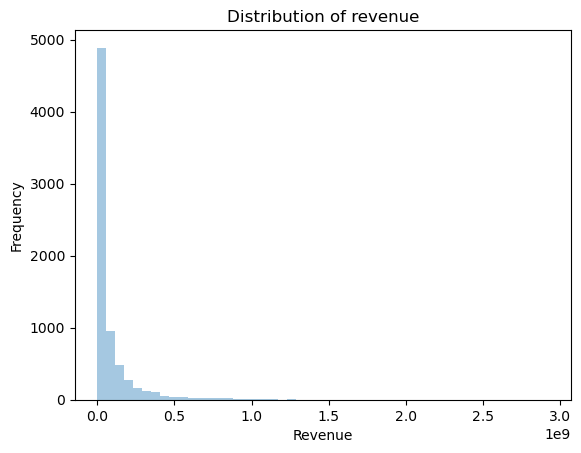

In [216]:
#plot the distribution of the revenue in the training set
sns.distplot(train['revenue'], kde=False)
plt.title('Distribution of revenue')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()

C:\Users\zjy\AppData\Local\Temp\ipykernel_28936\1025018483.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['original_budget'], kde=False)


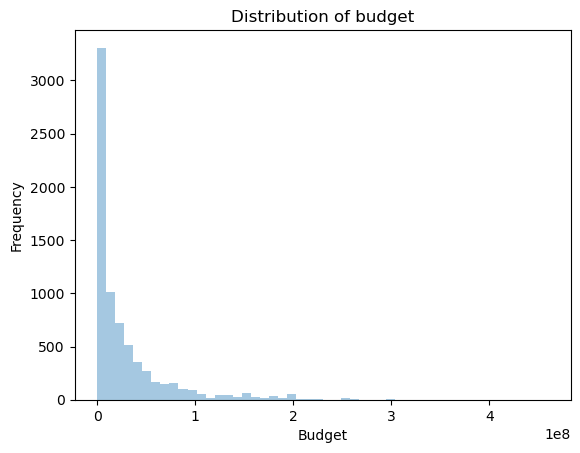

In [217]:
#plot the distribution of the budget in the training set
sns.distplot(train['original_budget'], kde=False)
plt.title('Distribution of budget')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.show()

C:\Users\zjy\AppData\Local\Temp\ipykernel_28936\668996526.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['log_revenue'], kde=False)


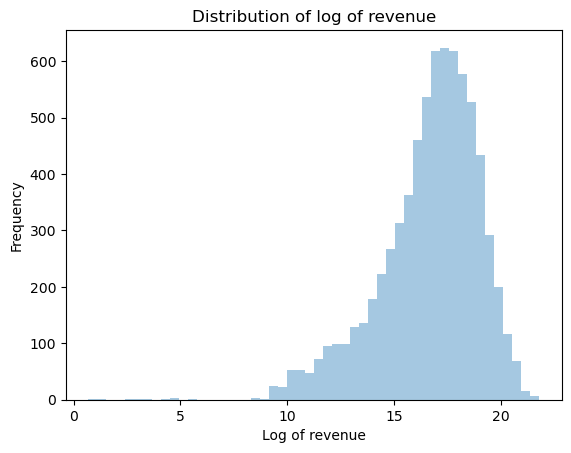

In [218]:
# plot the distribution of the log of the revenue in the training set
sns.distplot(train['log_revenue'], kde=False)
plt.title('Distribution of log of revenue')
plt.xlabel('Log of revenue')
plt.ylabel('Frequency')
plt.show()

C:\Users\zjy\AppData\Local\Temp\ipykernel_28936\3171513416.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['log_budget'], kde=False)


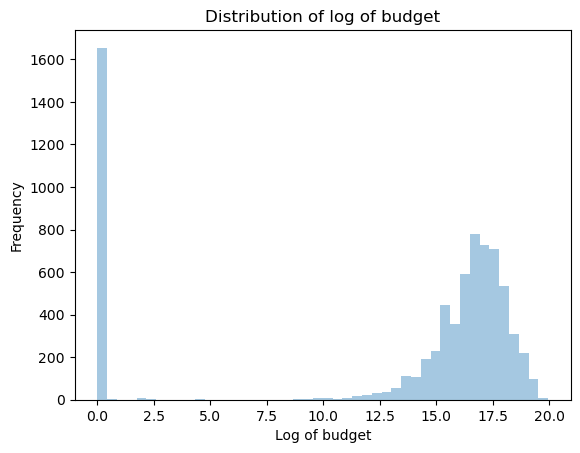

In [219]:
# plot the distribution of the log of the budget in the training set
sns.distplot(train['log_budget'], kde=False)
plt.title('Distribution of log of budget')
plt.xlabel('Log of budget')
plt.ylabel('Frequency')
plt.show()

By observing the plots above, we will divide the data into two parts: error and non-error and label them as 1 and 0 respectively. We will use these labels to train the error detection model.

In [220]:
#store all the data that is zero in budget or revenue in a new dataframe called error
#store all the data that is not zero in budget or revenue in a new dataframe called non_error_train
error_train = train[(train['revenue'] == 0) | (train['original_budget'] == 0)]
non_error_train = train[(train['original_budget'] != 0) & (train['revenue'] != 0)]

#move all the data whose log_budegt is less than 10 in non-error to the error dataframe
temp = non_error_train[non_error_train['log_budget'] < 8]
error_train = error_train._append(temp, ignore_index=True)
non_error_train = non_error_train[non_error_train['log_budget'] >= 8]

#move all the data whose log_revenue is less than 7.5 in non-error to the error dataframe
temp = non_error_train[non_error_train['log_revenue'] < 7.5]
error_train = error_train._append(temp, ignore_index=True)
non_error_train = non_error_train[non_error_train['log_revenue'] >= 7.5]

These plots shows the distribution of the errors and non-errors

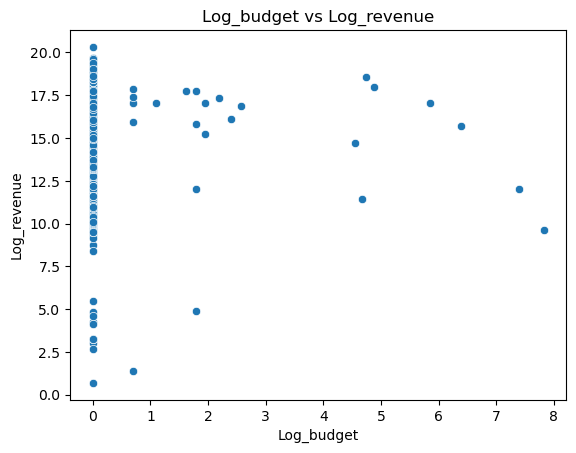

In [221]:
#plot the distribution of the log_budegt against the log_revenue in the error set
sns.scatterplot(x='log_budget', y='log_revenue', data=error_train)
plt.title('Log_budget vs Log_revenue')
plt.xlabel('Log_budget')
plt.ylabel('Log_revenue')
plt.show()

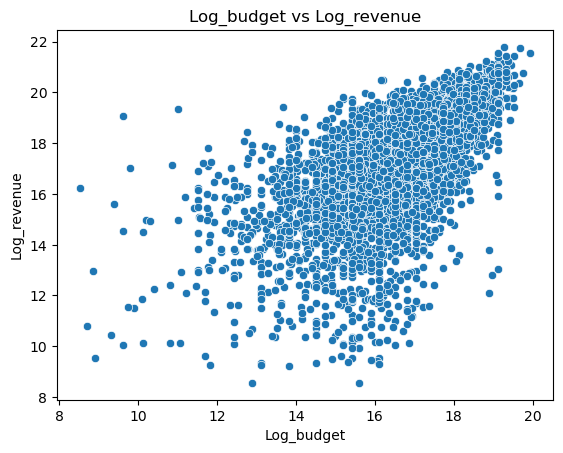

In [222]:
#plot the distribution of the log_budegt against the log_revenue in the non-error set
sns.scatterplot(x='log_budget', y='log_revenue', data=non_error_train)
plt.title('Log_budget vs Log_revenue')
plt.xlabel('Log_budget')
plt.ylabel('Log_revenue')
plt.show()

We can see than the log_budget and log_revenue has strong correlation in the non-errors and have weaker correlations in the errors.

In [223]:
#label the error set as 1 and the non-error set as 0
error_train['error'] = 1
non_error_train['error'] = 0
#combine the error and non-error set
train_labeled = error_train._append(non_error_train, ignore_index=True)

In [224]:
# split the training set into training and validation set, with a evenly distributed error and non-error set
train_labeled, val_labeled = train_test_split(train_labeled, test_size=0.2, random_state=42, stratify=train_labeled['error'])

#### 2. training

In this part, we will train the classifer by the trainning dataset.

In [225]:
# feature_classification selection
feature_classification = [ 'original_budget', 'budget_processed', 'genre_rank',
                            'inflationBudget', 'popularity_year_ratio']
# target
target = 'error'

# split the feature_classification and target in the training set
X_train = train_labeled[feature_classification]
y_train = train_labeled[target]
# split the feature_classification and target in the validation set
X_val = val_labeled[feature_classification]
y_val = val_labeled[target]

# create a lgb dataset for training
train_data = lgb.Dataset(X_train, label=y_train)
# create a lgb dataset for validation
val_data = lgb.Dataset(X_val, label=y_val)

# set the parameters for the lgb model
param = {'num_leaves': 30,
          'objective': 'binary',
          'metric': 'auc',
          'max_depth': 5,
          'learning_rate': 0.1,
          'feature_fraction': 0.9,
          'min_data_in_leaf': 5,
          'bagging_fraction': 0.9,
          'bagging_freq': 1,
          'lambda_l1': 1,
          'lambda_l2': 1,
          'verbose': -1}
# train the lgb model
lgb_error_detection = lgb.train(param, train_data, valid_sets=[val_data])

# predict the validation set
y_pred = lgb_error_detection.predict(X_val, num_iteration=lgb_error_detection.best_iteration)
# convert the prediction to binary
for i in range(len(y_pred)):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

# calculate the accuracy, precision, recall and f1 score
accuracy = sum(y_pred == y_val) / len(y_val)
print(accuracy)
precision = sum((y_pred == 1) & (y_val == 1)) / sum(y_pred == 1)
print(precision)
recall = sum((y_pred == 1) & (y_val == 1)) / sum(y_val == 1)
print(recall)
f1 = 2 * precision * recall / (precision + recall)
print(f1)

1.0
1.0
1.0
1.0


#### 3. save the model

In this part, we will save the model in case furtuer usage.

In [226]:
# save the model
lgb_error_detection.save_model('model/lgb_error_detection.pkl')

#### 4. prediction

In this part, we will use the classifier to identify the errors in the test dataset.

In [227]:
# predict the test set
y_pred = lgb_error_detection.predict(test[feature_classification], num_iteration=lgb_error_detection.best_iteration)
# convert the prediction to binary
for i in range(len(y_pred)):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
test['error'] = y_pred

In [228]:
# predict the error set using the error detection model
y_pred = lgb_error_detection.predict(error_train[feature_classification], num_iteration=lgb_error_detection.best_iteration)
# convert the prediction to binary
for i in range(len(y_pred)):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
error_train['error'] = y_pred

# split the test set into error and non-error set
error_test = test[test['error'] == 1]
non_error_test = test[test['error'] == 0]

In [229]:
print(error_test.shape)
print(non_error_test.shape)

(1245, 84)
(3153, 84)


### Models for revenue prediction

In this part, we will use 3 models: lightgbm, xgboost, and catboost. Then we will use the average of the predictions of these models as our final prediction.

Use Five-Fold Cross Validation to Evaluate the Model

In [230]:
# split the training set into training and validation set, use Five-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# we will use log_revenue as the target
target = 'log_revenue'

#### 1. Model for error-free data

In [231]:
# lightgbm
# set the parameters for the lgb model
param = {'num_leaves': 500,
          'objective': 'regression',
          'metric': 'rmse',
          'max_depth': 12,
          'learning_rate': 0.1,
          'feature_fraction': 0.9,
          'min_data_in_leaf': 5,
          'bagging_fraction': 0.9,
          'bagging_freq': 1,
          'lambda_l1': 0.2,
          'lambda_l2': 1,
          'verbose': -1}
# train the lgb model
lgb_model_non_error = []
lgb_prediction = []
for train_index, val_index in kf.split(non_error_train):
    X_train, X_val = non_error_train.iloc[train_index][feature_regression], non_error_train.iloc[val_index][feature_regression]
    y_train, y_val = non_error_train.iloc[train_index][target], non_error_train.iloc[val_index][target]
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    lgb_model = lgb.train(param, train_data, valid_sets=[val_data])
    lgb_model_non_error.append(lgb_model)
    # evaluate the model
    y_pred = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
    lgb_prediction.append(y_pred)
    # calculate the loss
    loss = np.sqrt(sum((y_pred - y_val) ** 2) / len(y_val))
    print(loss)



1.4360175778415776
1.2883667302228594
1.2457061237678082
1.3001139556327521
1.1820293383653027


In [232]:
# xgboost
# set the parameters for the xgb model
param = {'objective': 'reg:squarederror', 
              'eta': 0.035, 
              'max_depth': 17, 
              'subsample': 0.6, 
              'colsample_bytree': 0.7,  
              'eval_metric': 'rmse', 
              'verbose': False
}
# train the xgb model
xgb_model_non_error = []
xgb_prediction = []
for train_index, val_index in kf.split(non_error_train):
    X_train, X_val = non_error_train.iloc[train_index][feature_regression], non_error_train.iloc[val_index][feature_regression]
    y_train, y_val = non_error_train.iloc[train_index][target], non_error_train.iloc[val_index][target]
    train_data = xgb.DMatrix(X_train, label=y_train)
    val_data = xgb.DMatrix(X_val, label=y_val)
    xgb_model = xgb.train(param, train_data, evals=[(val_data, 'validation')])
    xgb_model_non_error.append(xgb_model)
    # evaluate the model
    y_pred = xgb_model.predict(val_data)
    xgb_prediction.append(y_pred)
    # calculate the loss
    loss = np.sqrt(sum((y_pred - y_val) ** 2) / len(y_val))
    print(loss)


[22:09:07] WARNING: D:\bld\xgboost-split_1700181111005\work\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation-rmse:16.10756
[1]	validation-rmse:15.54610


[2]	validation-rmse:15.00412
[3]	validation-rmse:14.48160
[4]	validation-rmse:13.97671
[5]	validation-rmse:13.49045
[6]	validation-rmse:13.02183
[7]	validation-rmse:12.56945
[8]	validation-rmse:12.13428
[9]	validation-rmse:11.71335
11.713347982152646
[22:09:07] WARNING: D:\bld\xgboost-split_1700181111005\work\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation-rmse:16.19495
[1]	validation-rmse:15.63069
[2]	validation-rmse:15.08989
[3]	validation-rmse:14.56665
[4]	validation-rmse:14.06162
[5]	validation-rmse:13.57419
[6]	validation-rmse:13.10616
[7]	validation-rmse:12.65328
[8]	validation-rmse:12.21697
[9]	validation-rmse:11.79518
11.795175278170476
[22:09:07] WARNING: D:\bld\xgboost-split_1700181111005\work\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation-rmse:16.27397
[1]	validation-rmse:15.71165
[2]	validation-rmse:15.16894
[3]	validation-rmse:14.64659
[4]	validation-rmse:14.14281
[5]	validation-rmse:13.65607


d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
d:\anaconda3\envs\F30\L

[6]	validation-rmse:13.18808
[7]	validation-rmse:12.73550
[8]	validation-rmse:12.29892
[9]	validation-rmse:11.87696
11.876962693574267
[22:09:07] WARNING: D:\bld\xgboost-split_1700181111005\work\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation-rmse:16.23310
[1]	validation-rmse:15.67290
[2]	validation-rmse:15.13204
[3]	validation-rmse:14.61088
[4]	validation-rmse:14.10675
[5]	validation-rmse:13.62089
[6]	validation-rmse:13.15343
[7]	validation-rmse:12.69969
[8]	validation-rmse:12.26329
[9]	validation-rmse:11.84335
11.843351631872306
[22:09:07] WARNING: D:\bld\xgboost-split_1700181111005\work\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation-rmse:16.39824
[1]	validation-rmse:15.83256
[2]	validation-rmse:15.28832
[3]	validation-rmse:14.76299
[4]	validation-rmse:14.25745
[5]	validation-rmse:13.76870
[6]	validation-rmse:13.29603
[7]	validation-rmse:12.84187
[8]	validation-rmse:12.40267
[9]	validation-rmse:11.97911
11.979111837528974


d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
d:\anaconda3\envs\F30\L

In [233]:
# catboost
# set the parameters for the cat model
param = {'iterations' : 2000,
        'learning_rate':0.07,
        'depth':12,
        'eval_metric':'RMSE',
        'colsample_bylevel':0.8,
        'bagging_temperature' : 0.4,
        'metric_period' : None,
        'early_stopping_rounds':200,
        'verbose': False
}
# train the cat model
cat_model_non_error = []
cat_prediction = []
for train_index, val_index in kf.split(non_error_train):
    X_train, X_val = non_error_train.iloc[train_index][feature_regression], non_error_train.iloc[val_index][feature_regression]
    y_train, y_val = non_error_train.iloc[train_index][target], non_error_train.iloc[val_index][target]
    train_data = cat.Pool(X_train, label=y_train)
    val_data = cat.Pool(X_val, label=y_val)
    cat_model = cat.CatBoostRegressor(**param)
    cat_model.fit(train_data, eval_set=val_data)
    cat_model_non_error.append(cat_model)
    # evaluate the model
    y_pred = cat_model.predict(val_data)
    cat_prediction.append(y_pred)
    # calculate the loss
    loss = np.sqrt(sum((y_pred - y_val) ** 2) / len(y_val))
    print(loss)

1.4186606701187794
1.282108567188844
1.2278109615912804
1.2866792377979899
1.1651567477463223


In [234]:
# predict function
def prediction(model, data):
    pred = []
    for i in range(len(model)):
        pred.append(model[i].predict(data))
    pred = np.array(pred)
    pred = np.mean(pred, axis=0)
    return pred

To combine these 3 types of models, we use linear regression to find the best weight.

In [235]:
# # train a linear regression model to adjust the prediction of the three models

# predict the training set using the three models
lgb_train = prediction(lgb_model_non_error, non_error_train[feature_regression])
xgb_train = prediction(xgb_model_non_error, xgb.DMatrix(non_error_train[feature_regression]))
cat_train = prediction(cat_model_non_error, cat.Pool(non_error_train[feature_regression]))

# combine the prediction of the three models
train_pred = np.array([lgb_train, xgb_train, cat_train])
train_pred = np.transpose(train_pred)
# train a linear regression model
lr_non_error = LinearRegression()
lr_non_error.fit(train_pred, non_error_train[target])



d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


LinearRegression()

#### 2. Model for error data

In [236]:
# lightgbm
# set the parameters for the lgb model
param = {'num_leaves': 500,
          'objective': 'regression',
          'metric': 'rmse',
          'max_depth': 12,
          'learning_rate': 0.1,
          'feature_fraction': 0.95,
          'min_data_in_leaf': 5,
          'bagging_fraction': 0.9,
          'bagging_freq': 1,
          'lambda_l1': 0.2,
          'lambda_l2': 1,
          'verbose': -1}

# train the lgb model
lgb_model_error = []
lgb_prediction = []
for train_index, val_index in kf.split(error_train):
    X_train, X_val = error_train.iloc[train_index][feature_regression], error_train.iloc[val_index][feature_regression]
    y_train, y_val = error_train.iloc[train_index][target], error_train.iloc[val_index][target]
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    lgb_model = lgb.train(param, train_data, valid_sets=[val_data])
    lgb_model_error.append(lgb_model)
    # evaluate the model
    y_pred = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
    lgb_prediction.append(y_pred)
    # calculate the loss
    loss = np.sqrt(sum((y_pred - y_val) ** 2) / len(y_val))
    print(loss)


1.7682569677535886
1.8138071892010714
1.9679283891110555
1.5136034789061503
1.556742971045209


In [237]:
# xgboost
# set the parameters for the xgb model
param = {'objective': 'reg:squarederror', 
              'eta': 0.035, 
              'max_depth': 17, 
              'subsample': 0.6, 
              'colsample_bytree': 0.7,  
              'eval_metric': 'rmse', 
              'verbose': False
}
# train the xgb model
xgb_model_error = []
xgb_prediction = []
for train_index, val_index in kf.split(error_train):
    X_train, X_val = error_train.iloc[train_index][feature_regression], error_train.iloc[val_index][feature_regression]
    y_train, y_val = error_train.iloc[train_index][target], error_train.iloc[val_index][target]
    train_data = xgb.DMatrix(X_train, label=y_train)
    val_data = xgb.DMatrix(X_val, label=y_val)
    xgb_model = xgb.train(param, train_data, evals=[(val_data, 'validation')])
    xgb_model_error.append(xgb_model)
    # evaluate the model
    y_pred = xgb_model.predict(val_data)
    xgb_prediction.append(y_pred)
    # calculate the loss
    loss = np.sqrt(sum((y_pred - y_val) ** 2) / len(y_val))
    print(loss)


[22:16:03] WARNING: D:\bld\xgboost-split_1700181111005\work\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation-rmse:14.17726
[1]	validation-rmse:13.69800


[2]	validation-rmse:13.23465
[3]	validation-rmse:12.78727
[4]	validation-rmse:12.35412
[5]	validation-rmse:11.93784
[6]	validation-rmse:11.53592
[7]	validation-rmse:11.14878
[8]	validation-rmse:10.78151
[9]	validation-rmse:10.42076
10.420764250600719
[22:16:03] WARNING: D:\bld\xgboost-split_1700181111005\work\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation-rmse:13.99931
[1]	validation-rmse:13.52325
[2]	validation-rmse:13.06226
[3]	validation-rmse:12.61922
[4]	validation-rmse:12.19009
[5]	validation-rmse:11.77786
[6]	validation-rmse:11.38858
[7]	validation-rmse:11.00716
[8]	validation-rmse:10.63856
[9]	validation-rmse:10.28328
10.283283350890823
[22:16:03] WARNING: D:\bld\xgboost-split_1700181111005\work\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation-rmse:13.89105
[1]	validation-rmse:13.41508
[2]	validation-rmse:12.95482
[3]	validation-rmse:12.51521
[4]	validation-rmse:12.08882
[5]	validation-rmse:11.67841
[6]	validation-rmse:11

d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
d:\anaconda3\envs\F30\L

[9]	validation-rmse:10.17471
10.174704999871743
[22:16:03] WARNING: D:\bld\xgboost-split_1700181111005\work\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation-rmse:13.97607
[1]	validation-rmse:13.49275
[2]	validation-rmse:13.02371
[3]	validation-rmse:12.57374
[4]	validation-rmse:12.14608
[5]	validation-rmse:11.73010
[6]	validation-rmse:11.32849
[7]	validation-rmse:10.93782
[8]	validation-rmse:10.56450
[9]	validation-rmse:10.20375
10.203745282266208
[22:16:03] WARNING: D:\bld\xgboost-split_1700181111005\work\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation-rmse:14.08072
[1]	validation-rmse:13.59777
[2]	validation-rmse:13.13816
[3]	validation-rmse:12.69372
[4]	validation-rmse:12.26389
[5]	validation-rmse:11.84754
[6]	validation-rmse:11.44945
[7]	validation-rmse:11.06234
[8]	validation-rmse:10.69342
[9]	validation-rmse:10.33395
10.33395014689389


d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
d:\anaconda3\envs\F30\L

In [238]:
# catboost
# set the parameters for the cat model
param = {'iterations' : 2000,
        'learning_rate':0.07,
        'depth':12,
        'eval_metric':'RMSE',
        'colsample_bylevel':0.8,
        'bagging_temperature' : 0.4,
        'metric_period' : None,
        'early_stopping_rounds':200,
        'verbose': False
}
# train the cat model
cat_model_error = []
cat_prediction = []
for train_index, val_index in kf.split(error_train):
    X_train, X_val = error_train.iloc[train_index][feature_regression], error_train.iloc[val_index][feature_regression]
    y_train, y_val = error_train.iloc[train_index][target], error_train.iloc[val_index][target]
    train_data = cat.Pool(X_train, label=y_train)
    val_data = cat.Pool(X_val, label=y_val)
    cat_model = cat.CatBoostRegressor(**param)
    cat_model.fit(train_data, eval_set=val_data)
    cat_model_error.append(cat_model)
    # evaluate the model
    y_pred = cat_model.predict(val_data)
    cat_prediction.append(y_pred)
    # calculate the loss
    loss = np.sqrt(sum((y_pred - y_val) ** 2) / len(y_val))
    print(loss)
    

1.7533005437590408
1.7181649597227462
2.002453464092789
1.5251076394618415
1.5766780340481517


To combine these 3 types of models, we use linear regression to find the best weight.

In [239]:
# train a linear regression model to adjust the prediction of the three models

lgb_train = prediction(lgb_model_error, error_train[feature_regression])
# data = xgb.DMatrix(error_train[feature_regression], label=error_train[target])
xgb_train = prediction(xgb_model_error, xgb.DMatrix(error_train[feature_regression]))
cat_train = prediction(cat_model_error, cat.Pool(error_train[feature_regression]))

# combine the prediction of the three models
train_pred = np.array([lgb_train, xgb_train, cat_train])
train_pred = np.transpose(train_pred)
# train a linear regression model
lr_error = LinearRegression()
lr_error.fit(train_pred, error_train[target])


d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


LinearRegression()

### Prediction

In this part, we will use model for error-free data and model for error data to predict.

In [240]:
# print the coefficients of the linear regression model for the error set and non-error set
print(lr_error.coef_)
print(lr_non_error.coef_)

[ 1.01501282 -0.67925275  0.21011411]
[ 0.92621608 -0.80338887  0.29692235]


Based on the kaggle score, we find that the predict result of linear regression combination is not satisfing. So we set the coefficient by ourselves.

In [241]:
#lgb: 2.18553
#xgb: 11.08401
#cat: 2.17609
coef = [0.45, 0, 0.55]
#Because of the poor performance of the xgboost model, we give it a 0 weight

# predict the non-error set using the three models
lgb_non_error = prediction(lgb_model_non_error, non_error_test[feature_regression])
xgb_non_error = prediction(xgb_model_non_error, xgb.DMatrix(non_error_test[feature_regression]))
cat_non_error = prediction(cat_model_non_error, cat.Pool(non_error_test[feature_regression]))

# predict the non-error set using the linear regression model
#y_pred = np.mean([lgb_non_error, xgb_non_error, cat_non_error], axis=0)
#y_pred = lr_non_error.predict(np.array([lgb_non_error, xgb_non_error, cat_non_error]).T)

# use the coefficients calculated above to adjust the prediction
y_pred = np.dot(np.array([lgb_non_error, xgb_non_error, cat_non_error]).T, coef)


non_error_test['revenue'] = np.expm1(y_pred)

print(non_error_test.shape)
# predict the error set using the three models
lgb_error = prediction(lgb_model_error, error_test[feature_regression])
xgb_error = prediction(xgb_model_error, xgb.DMatrix(error_test[feature_regression]))
cat_error = prediction(cat_model_error, cat.Pool(error_test[feature_regression]))

# predict the error set using the linear regression model
#y_pred = lr_error.predict(np.array([lgb_error, xgb_error, cat_error]).T)

# use the coefficients calculated above to adjust the prediction
y_pred = np.dot(np.array([lgb_error, xgb_error, cat_error]).T, coef)

error_test['revenue'] = np.expm1(y_pred)

d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
d:\anaconda3\envs\F30\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\Users\zjy\AppData\Lo

(3153, 84)


C:\Users\zjy\AppData\Local\Temp\ipykernel_28936\2110619882.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_test['revenue'] = np.expm1(y_pred)


In [242]:
# combine the error and non-error set
test = error_test._append(non_error_test, ignore_index=False)
test

,Unnamed: 0,imdb_id,id,belongs_to_collection,original_budget,budget_processed,genre_rank,num_genres,has_homepage,originally_english,...,month,year,day_of_week,week_of_year,log_budget,_budget_runtime_ratio,_budget_popularity_ratio,day,log_budget_p,error
0,0,tt1226251,3001,1,0,1.200000e+07,17.25,4,1,0,...,7,2007,6,28,0.000000,133333.333333,3.115642e+06,14,16.300417,1.0
2,2,tt0118556,3003,0,0,4.818003e+07,9.50,2,0,1,...,5,1997,5,21,0.000000,481800.291700,5.959044e+06,23,17.690455,1.0
5,5,tt0120238,3006,0,0,2.882751e+07,7.50,2,0,1,...,2,1996,3,6,0.000000,238243.869835,3.321390e+06,7,17.176841,1.0
6,6,tt1517177,3007,0,0,5.775155e+07,8.00,3,0,0,...,12,2010,4,51,0.000000,485307.107143,1.178872e+07,23,17.871661,1.0
11,11,tt3655522,3012,0,0,5.140572e+06,5.00,1,0,0,...,6,2014,5,26,0.000000,45897.967634,1.218053e+06,27,15.452675,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,4393,tt0218922,7394,0,42000000,4.200000e+07,8.00,1,0,1,...,3,2008,6,9,17.553180,355932.203390,4.212486e+06,1,17.553180,0.0
4394,4394,tt0364751,7395,1,19000000,1.900000e+07,12.75,4,0,1,...,8,2004,5,34,16.759950,200000.000000,3.142305e+06,20,16.759950,0.0
4395,4395,tt0084855,7396,0,16000000,1.600000e+07,5.00,1,0,1,...,12,1982,3,49,16.588099,124031.007752,1.667208e+06,8,16.588099,0.0
4396,4396,tt3235888,7397,0,2000000,2.000000e+06,7.50,2,0,1,...,4,2002,1,16,14.508658,20000.000000,9.823503e+04,15,14.508658,0.0


In [243]:
df_LXC = pd.DataFrame()
sub= ['id','revenue']
df_LXC[sub]=test[sub]
df_LXC.sort_values(by='id', inplace=True)
df_LXC.to_csv("submission_LXC.csv", index=False)
# 2.16366

# Aggregation

In [244]:
# df_LR, df_RF, df_LXC
# merge by id
df_aggregate = pd.merge(df_LR, df_RF, on='id')
df_aggregate = pd.merge(df_aggregate, df_LXC, on='id')

# set the weight of each model
weight = [1, -0.0004, 0.0004]

# calculate the weighted average
df_aggregate['revenue'] = weight[0] * df_aggregate['revenue_x'] + weight[1] * df_aggregate['revenue_y'] + weight[2] * df_aggregate['revenue']
# drop the columns that are not needed
df_aggregate = df_aggregate.drop(['revenue_x', 'revenue_y'], axis=1)

# save the result
df_aggregate.to_csv('submission_aggregate.csv', index=False)

# 1.96185